In [118]:
import numpy as np
import xarray as xr
import dask as da
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.signal as signal
%matplotlib notebook

## Leith/NoLeith comaprison

These were run with No Leith viscosity and with Leith viscosity:

```
 viscC4Leith=2.15,
 viscC4Leithd=2.15,
 viscA4GridMax=0.8,
 useAreaViscLength=.TRUE.,
 viscAz=1.E-5,
 viscAh=1.E-5,
 no_slip_sides=.FALSE.,
 no_slip_bottom=.FALSE.,
 diffKhT=1.E-5,
 diffKzT=1.E-5,
```
The forcing was supposed to be tidal, but didn't turn out to be a very good tide (didn't force boudnarie properly, started impulsively, etc, so there was a good inertial component as well.  I also added a small forcing at 5.67 (random number) times the tidal frequency, though the amplitude of this was 1/3 the tidal forcing  This extra forcing was just to add some high-frequency energy to the problem. 

Note that $dx=dy=1000\ \mathrm{m}$ and $dz=20\ \mathrm{m}$

The results are as documented below.  There is high vertical and horizontal wavenumber roll-off in Leith even when avoiding regions with large grid-scale noise in the Non-Leith runs.  

Possible todos - run at very high resolution to get a "truth" at least to higher wavenumber.  i.e. 100-m x 100-m x 10-m

These runs are 32-cores and take about 3-h to run.  100x100x10 would be about 1600 times more expensive (dt = 6.2 s instead fo 50 s) 

<IPython.core.display.Javascript object>


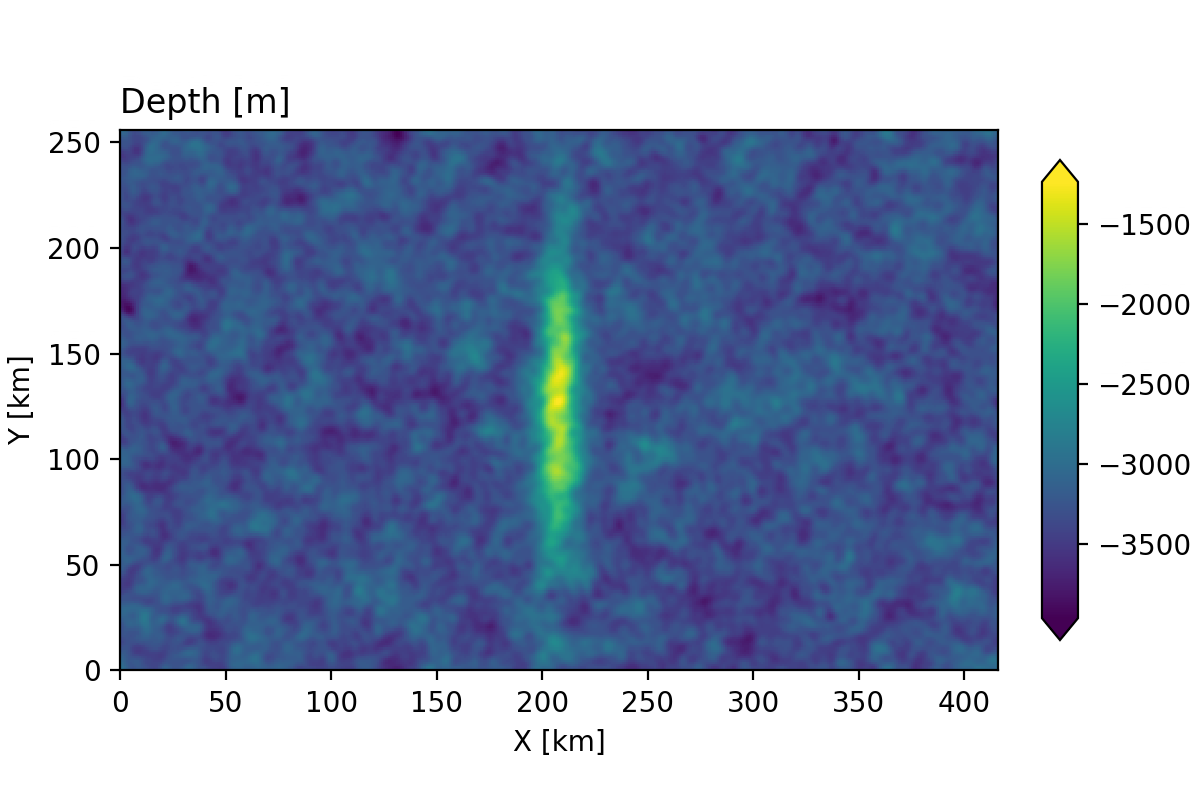

In [154]:
fig, axs = plt.subplots(1,1, sharex=True, sharey=True, figsize=(6,4), constrained_layout=True, 
                       squeeze=False)
for nn, fn in enumerate(['../reduceddata/IWNoLeith/Level0050.nc']):
    k = 10
    p = np.zeros((256, 80))
    ax = axs[0,0]
    with xr.open_dataset(fn) as dss:
        pc = ax.pcolormesh(-dss.Depth, cmap='viridis')
        fig.colorbar(pc, ax=ax, shrink=0.6, extend='both', )
        ax.set_xlabel('X [km]')
        ax.set_ylabel('Y [km]')
        ax.set_aspect(1.)
        ax.set_title('Depth [m]', loc='left')


<IPython.core.display.Javascript object>


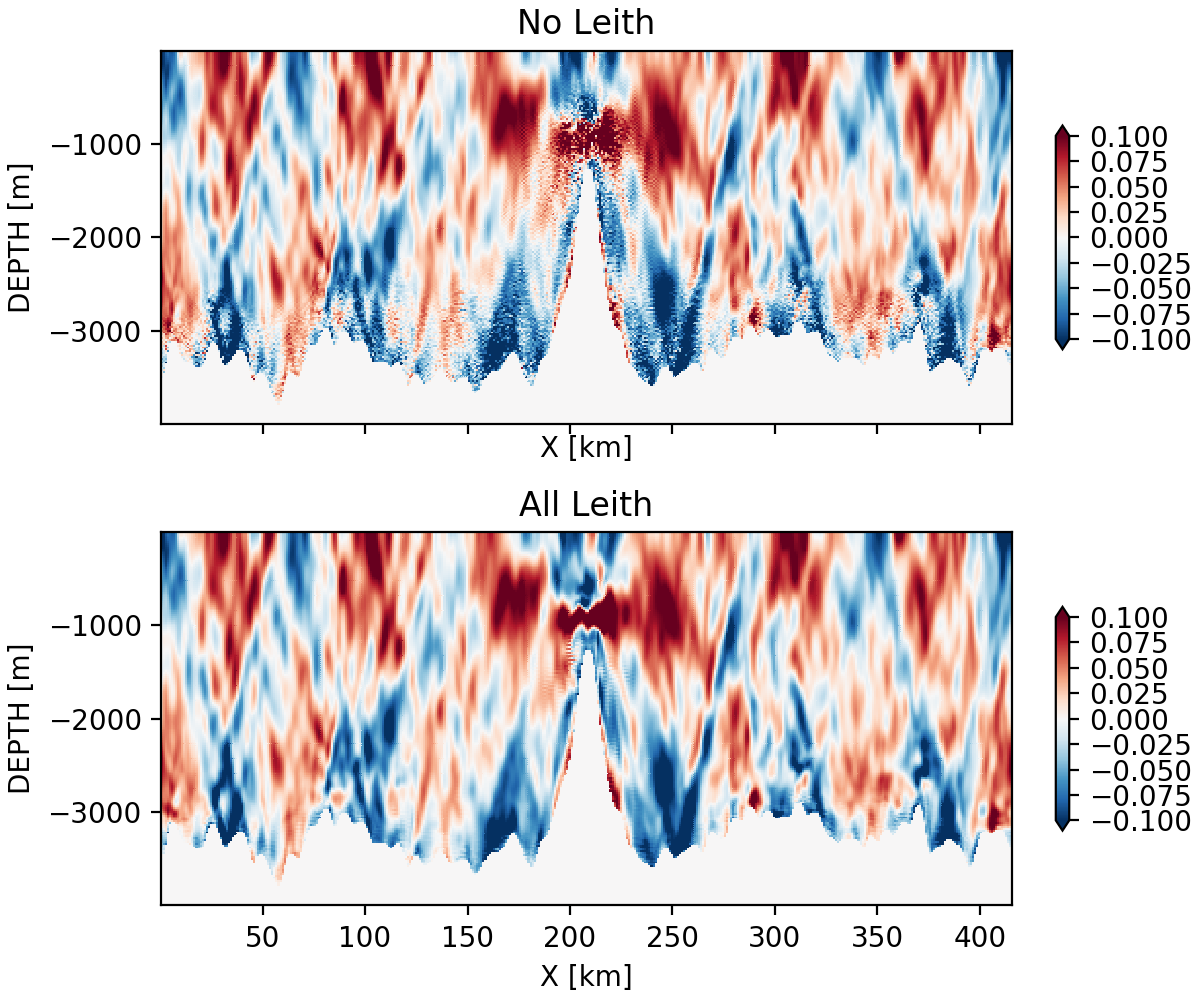

In [131]:
fig, axs = plt.subplots(2,1, sharex=True, sharey=True, figsize=(6,5), constrained_layout=True)
titl = ['No Leith', 'All Leith']

for nn, fn in enumerate(['../reduceddata/IWNoLeith/AllSlice.nc', 
                        '../reduceddata/IWAllLeith/AllSlice.nc']):
    k = 10
    ax = axs[nn]
    with xr.open_dataset(fn) as dss:
        pcm=ax.pcolormesh(dss.XC/1e3, dss.Z, dss.UVEL, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
        fig.colorbar(pcm, ax=ax, shrink=0.6, extend='both')   
        ax.set_title(titl[nn])
        ax.set_xlabel('X [km]')
        ax.set_ylabel('DEPTH [m]')

<IPython.core.display.Javascript object>


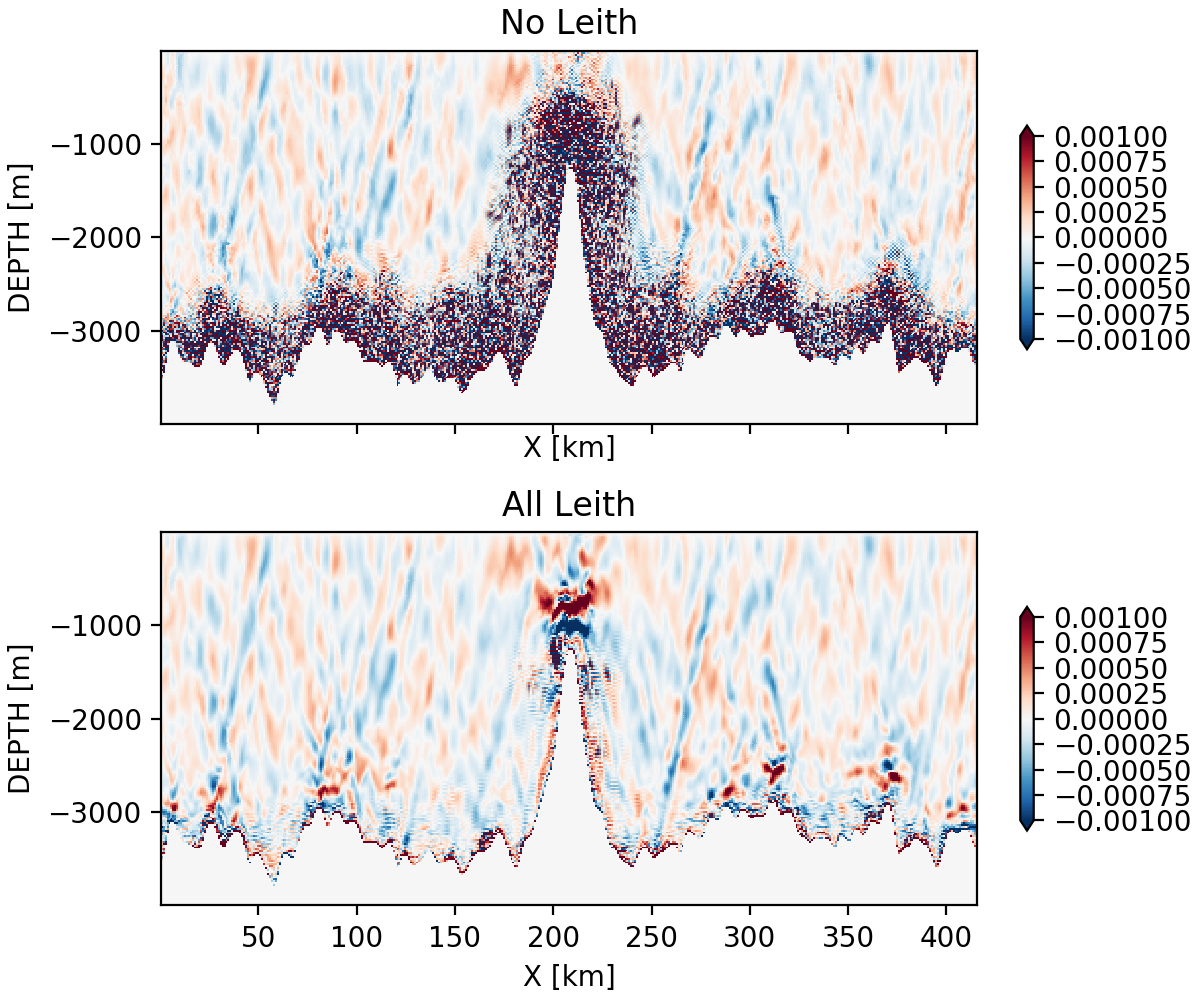

In [190]:
fig, axs = plt.subplots(2,1, sharex=True, sharey=True, figsize=(6,5), constrained_layout=True)
titl = ['No Leith', 'All Leith']

for nn, fn in enumerate(['../reduceddata/IWNoLeith/AllSlice.nc', 
                        '../reduceddata/IWAllLeith/AllSlice.nc']):
    k = 10
    ax = axs[nn]
    with xr.open_dataset(fn) as dss:
        pcm=ax.pcolormesh(dss.XC/1e3, dss.Z, np.diff(dss.UVEL.data, axis=0)/20., 
                          cmap='RdBu_r', vmin=-0.001, vmax=0.001)
        fig.colorbar(pcm, ax=ax, shrink=0.6, extend='both')   
        ax.set_title(titl[nn])
        ax.set_xlabel('X [km]')
        ax.set_ylabel('DEPTH [m]')

<IPython.core.display.Javascript object>


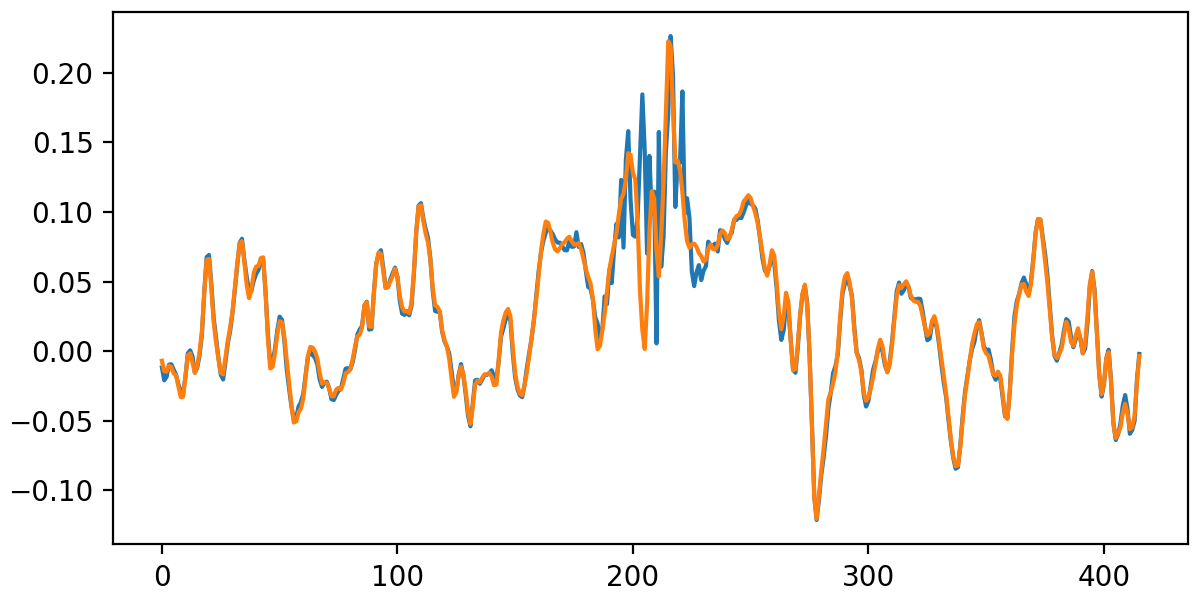

In [133]:
fig, axs = plt.subplots(1,1, sharex=True, sharey=True, figsize=(6, 3), constrained_layout=True)
for nn, fn in enumerate(['../reduceddata/IWNoLeith/AllSlice.nc', 
                        '../reduceddata/IWAllLeith/AllSlice.nc']):
    k = 10
    ax = axs
    with xr.open_dataset(fn) as dss:
        ax.plot(dss.UVEL[50, :])  

<IPython.core.display.Javascript object>


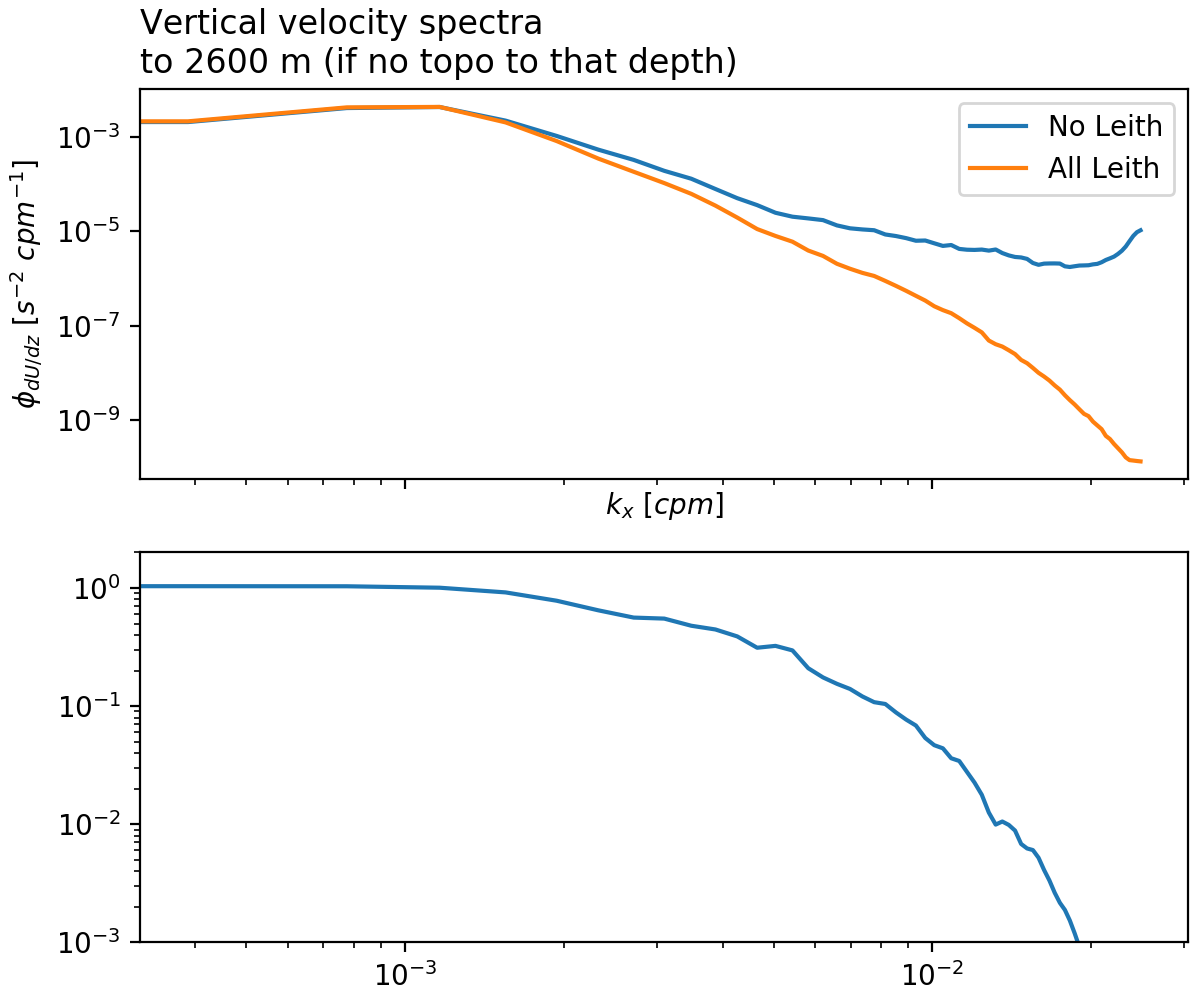

/Users/jklymak/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1785: UserWarning: nperseg = 256 is greater than input length  = 129, using nperseg = 129
  .format(nperseg, input_length))


(0.001, 2)

In [208]:
# Vertical spectra:

fig, axs = plt.subplots(2,1, sharex=True, sharey=False, figsize=(6, 5), constrained_layout=True)
pnoleith=None
for nn, fn in enumerate(['../reduceddata/IWNoLeith/AllSlice.nc', 
                        '../reduceddata/IWAllLeith/AllSlice.nc']):
    k = 10
    ax = axs[0]
    p = None
    with xr.open_dataset(fn) as dss:
        nx = len(dss.XC.data)
        U = np.ma.masked_where(dss.THETA.data<1, dss.UVEL.data)
        V = np.ma.masked_where(dss.THETA.data<1, dss.VVEL.data)
        todo = list(range(150)) + list(range(nx-150, nx))
        for i in todo:
            nz = 130
            if not np.ma.is_masked(U[:nz, i]):
                f, pp  = signal.welch(np.diff(U[:nz, i], axis=0), fs=1/20)
                f, ppv = signal.welch(np.diff(V[:nz, i], axis=0), fs=1/20)
                if p is None:
                    p = np.zeros((nx, len(f)))

                p[i,:] = (pp+ppv)/2
            else:
                p[i,:] = np.NaN
        p = np.ma.masked_invalid(p)
        if pnoleith is None:
            pnoleith = p.mean(axis=0)
        ax.loglog(f, p.mean(axis=0), label=titl[nn])
    ax.legend()
    ax.set_xlabel('$k_x\ [cpm]$')
    ax.set_ylabel('$\phi_{dU/dz}\ [s^{-2}\ cpm^{-1}]$')
    ax.set_title('Vertical velocity spectra\n'
                 'to %d m (if no topo to that depth)'%(nz*20), loc='left')    
ax = axs[1]
ax.loglog(f, p.mean(axis=0)/pnoleith)
ax.set_ylim([1e-3, 2])

<IPython.core.display.Javascript object>


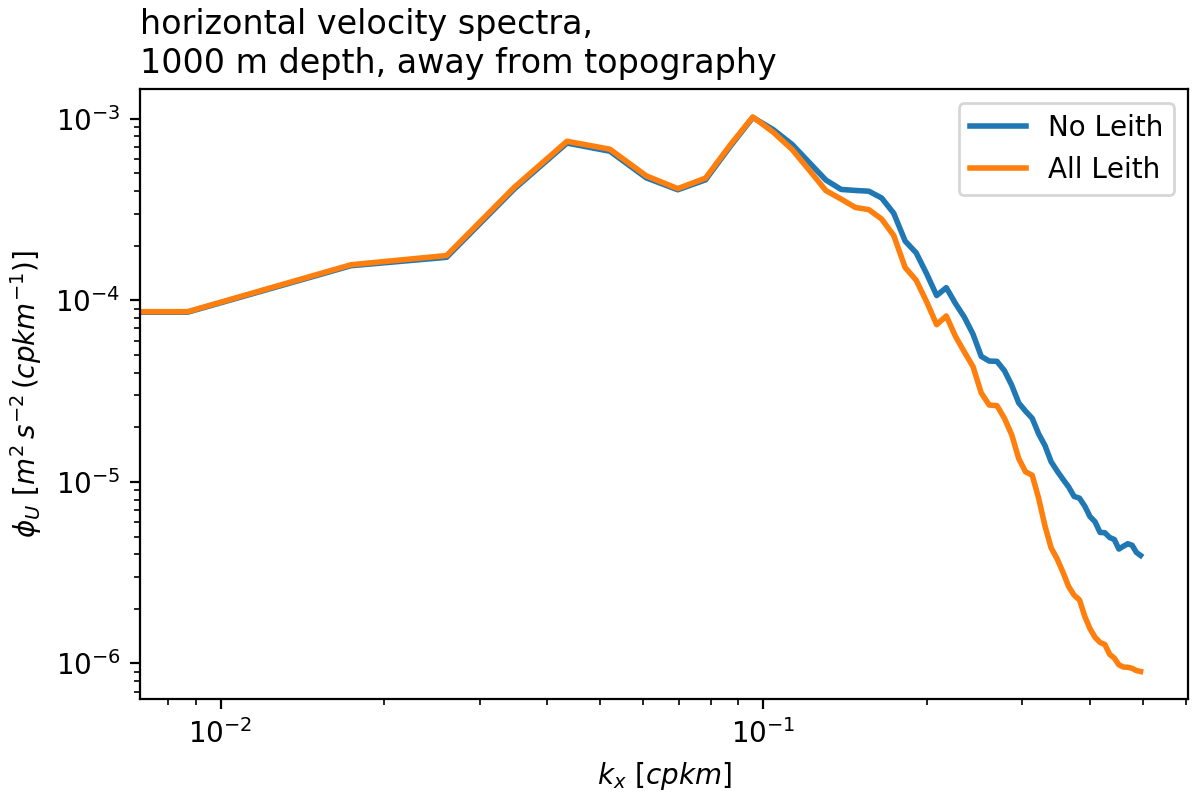

/Users/jklymak/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1785: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))


In [161]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(6, 4), constrained_layout=True)
for nn, fn in enumerate(['../reduceddata/IWNoLeith/Level0050.nc', 
                        '../reduceddata/IWAllLeith/Level0050.nc']):
    k = 10
    p = None
    with xr.open_dataset(fn) as dss:
        for j in range(256):
            f, pp = signal.welch(np.diff(dss.UVEL[j,300:].data))
            f, ppv = signal.welch(np.diff(dss.VVEL[j,300:].data))
            if p is None:
                p = np.zeros((256, len(f)))
            p[j,:] = (pp+ppv)/2
            # ax.loglog(f, p[j,:],'.')
        ax.loglog(f, p.mean(axis=0), linewidth=2, label=titl[nn])
    ax.set_xlabel('$k_x\ [cpkm]$')
    ax.set_ylabel('$\phi_U\ [m^2\,s^{-2} \,(cpkm^{-1})]$')
    ax.legend()
    ax.set_title('horizontal velocity spectra, \n1000 m depth, away from topography', loc='left')

<IPython.core.display.Javascript object>


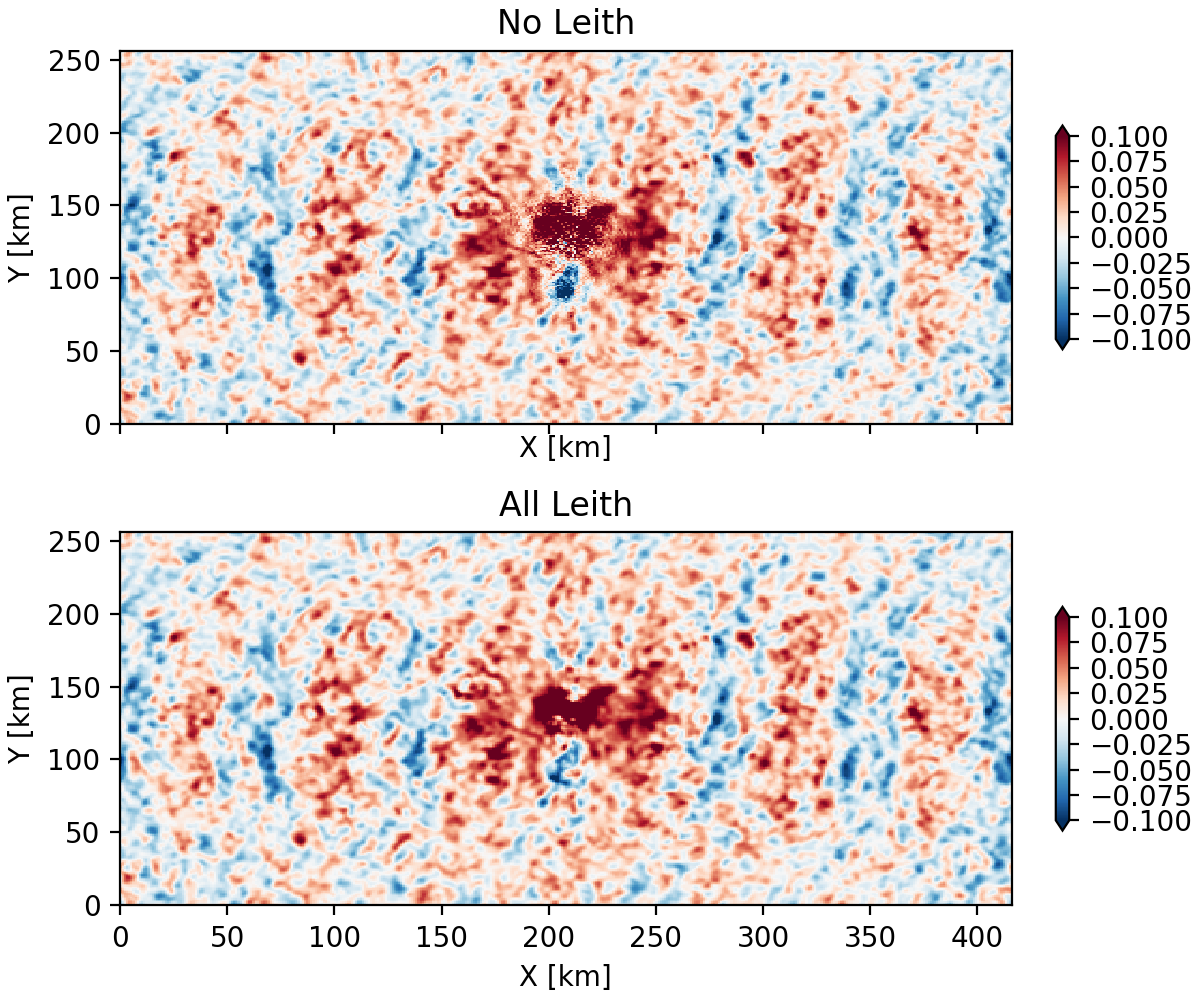

In [139]:
fig, axs = plt.subplots(2,1, sharex=True, sharey=True, figsize=(6,5), constrained_layout=True)
for nn, fn in enumerate(['../reduceddata/IWNoLeith/Level0050.nc', 
                        '../reduceddata/IWAllLeith/Level0050.nc']):
    k = 10
    p = np.zeros((256, 80))
    ax = axs[nn]
    with xr.open_dataset(fn) as dss:
        pc = ax.pcolormesh(dss.UVEL, vmin=-0.1, vmax=0.1, cmap='RdBu_r')
        fig.colorbar(pc, ax=ax, shrink=0.6, extend='both')
        ax.set_title(titl[nn])
        ax.set_xlabel('X [km]')
        ax.set_ylabel('Y [km]')


<IPython.core.display.Javascript object>


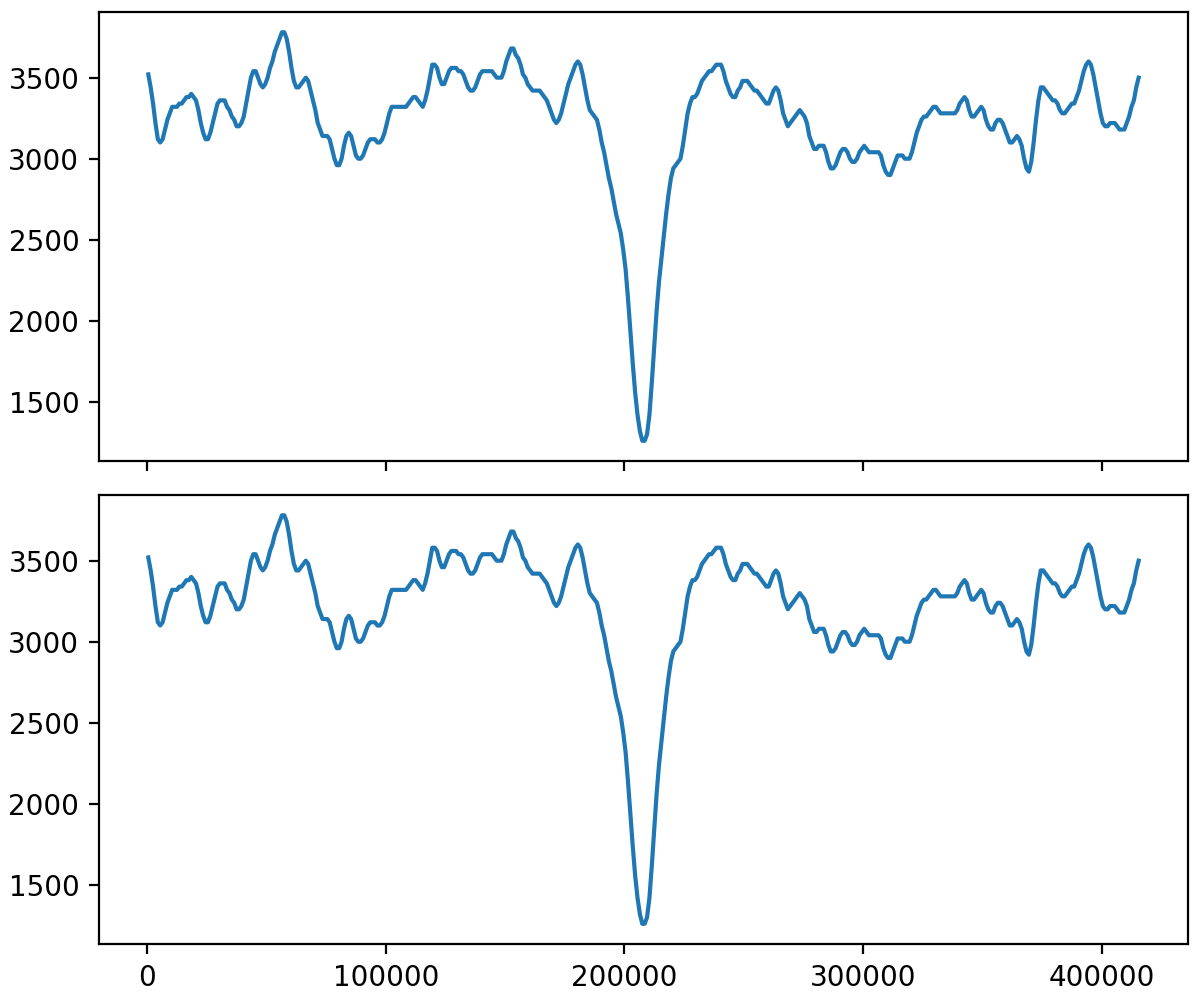

17.0
<xarray.DataArray 'UVEL' (k: 200, i_g: 416)>
array([[-0.109594, -0.094457, -0.080332, ..., -0.108744, -0.112471, -0.114736],
       [-0.108828, -0.094657, -0.081707, ..., -0.108512, -0.111914, -0.113865],
       [-0.107945, -0.095077, -0.083347, ..., -0.106623, -0.10989 , -0.112129],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ]])
Coordinates:
    record   int32 ...
  * i_g      (i_g) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    j        int32 ...
    j_g      int32 ...
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    XG       (i_g) float64 ...
    YG       (i_g) float64 ...
Attributes:
    description:  Zonal Component of Velocity (m/s)
    units:        m/s
17.0
<xarray.DataArray 'UVEL' (k: 200, i_g: 416)>
array([[-0.11247 ,

In [121]:
fig, axs = plt.subplots(2,1, sharex=True, sharey=True, figsize=(6,5), constrained_layout=True)
for nn, fn in enumerate(['../reduceddata/IWNoLeith/AllSlice.nc', 
                        '../reduceddata/IWAllLeith/AllSlice.nc']):
    k = 10
    ax = axs[nn]
    with xr.open_dataset(fn) as dss:
        print(float(dss.time.data/3600/12.4/1e9))
        print(dss.UVEL)
        pcm=ax.plot(dss.XC, dss.Depth) #, cmap='RdBu_r', vmin=-0.1, vmax=0.1)


<IPython.core.display.Javascript object>


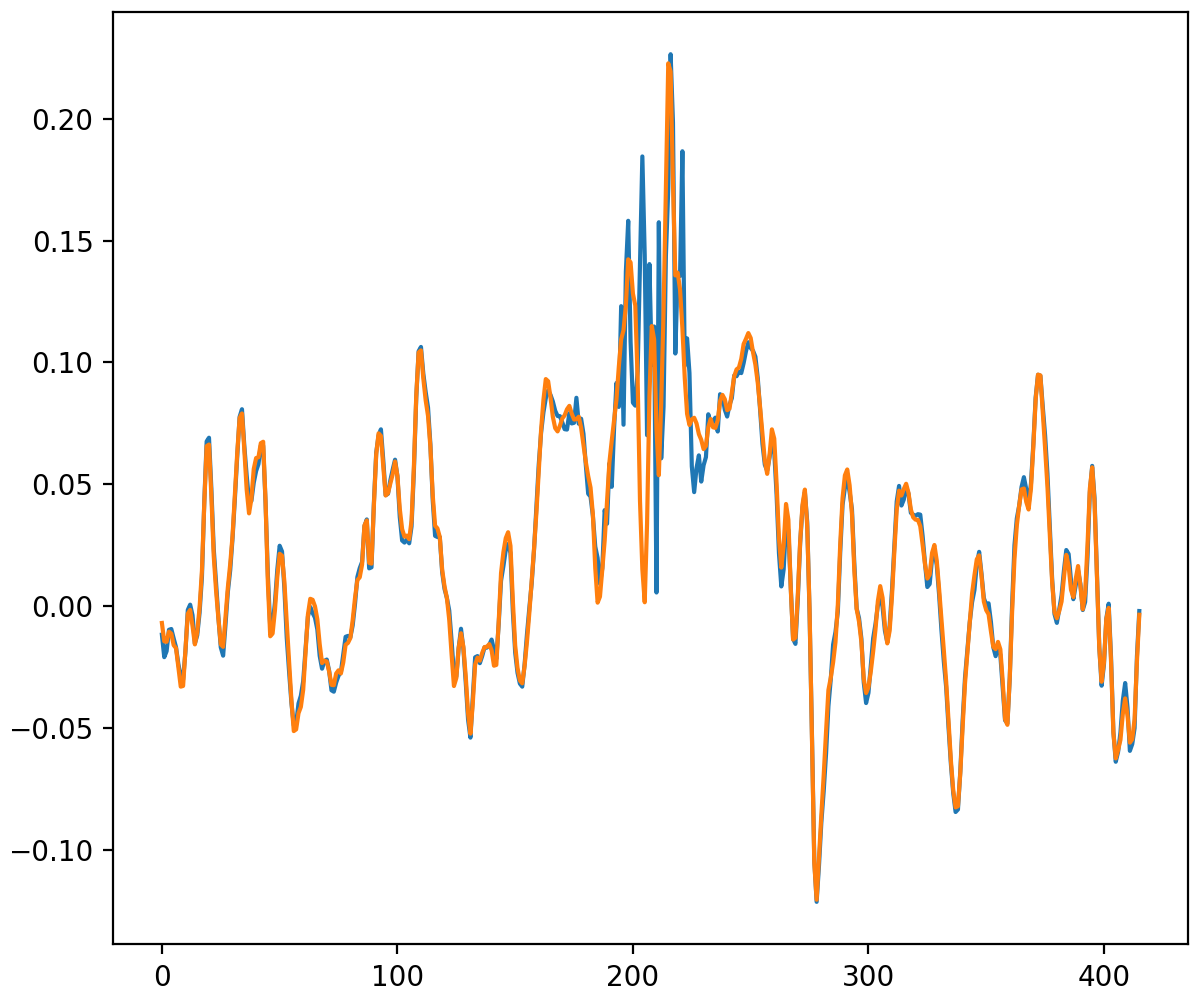

In [128]:
fig, axs = plt.subplots(1,1, sharex=True, sharey=True, figsize=(6,5), constrained_layout=True)
for nn, fn in enumerate(['../reduceddata/IWNoLeith/Level0050.nc', 
                        '../reduceddata/IWAllLeith/Level0050.nc']):
    k = 10
    p = np.zeros((256, 80))
    ax = axs
    with xr.open_dataset(fn) as dss:
        ax.plot(dss.UVEL[128, :])
        